# Predicting Crab1314

The preprocessed Crab1314 data will be fed into the best model in the assigned folder. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import os

In [2]:
model_folder_name = '16_pre-cccfff'
batch_size = 10000

meta_loading_folder = '/fhgfs/users/jbehnken/01_Data/04_Models/16_pre-cccfff/models_folder/103_with_5_100_pre_flat'
meta_loading_path = '/fhgfs/users/jbehnken/01_Data/04_Models/16_pre-cccfff/models_folder/103_with_5_100_pre_flat/First_Layer.meta'
prediction_save_path = '/fhgfs/users/jbehnken/01_Data/04_Models/16_pre-cccfff/models_folder/103_with_5_100_pre_flat/Prediction.csv'

In [3]:
def batchYielder():
    with h5py.File('/fhgfs/users/jbehnken/01_Data/02_Crab_Prediction/Crab1314_Images.h5', 'r') as hdf:
        items = list(hdf.items())[0][1].shape[0]
        i = 0

        while (i+1)*batch_size < items/1: # 160 factor to not process everything
            night = np.array(hdf['Night'][ i*batch_size:(i+1)*batch_size ])
            run = np.array(hdf['Run'][ i*batch_size:(i+1)*batch_size ])
            event = np.array(hdf['Event'][ i*batch_size:(i+1)*batch_size ])
            images = np.array(hdf['Image'][ i*batch_size:(i+1)*batch_size ])

            i += 1
            print(i)
            yield (night, run, event, images)

In [4]:
gpu_config = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.55)
session_conf = tf.ConfigProto(gpu_options=gpu_config, intra_op_parallelism_threads=18, inter_op_parallelism_threads=18)


with tf.Session(config=session_conf) as sess:
    saver = tf.train.import_meta_graph(meta_loading_path)    
    saver.restore(sess, tf.train.latest_checkpoint(meta_loading_folder))
    
    graph = tf.get_default_graph()
    
    #print(sess.graph.get_operations())
    
    try:
        conv2d_1_weights = graph.get_tensor_by_name("W_1:0")
        conv2d_1_biases = graph.get_tensor_by_name("B_1:0")
        print('Conv2d_1', conv2d_1_weights.shape)
    except: pass
    
    try:
        conv2d_2_weights = graph.get_tensor_by_name("W_2:0")
        conv2d_2_biases = graph.get_tensor_by_name("B_2:0")
        print('Conv2d_2', conv2d_2_weights.shape)
    except: pass
    
    try:
        conv2d_3_weights = graph.get_tensor_by_name("W_3:0")
        conv2d_3_biases = graph.get_tensor_by_name("B_3:0")
        print('Conv2d_3', conv2d_3_weights.shape)
    except: pass
    
    try:
        fc_1_weights = graph.get_tensor_by_name("W_4:0")
        fc_1_biases = graph.get_tensor_by_name("B_4:0")
        print('Fc_1', fc_1_weights.shape)
    except: pass
    
    try:
        fc_2_weights = graph.get_tensor_by_name("5_fc_2/W:0")
        fc_2_biases = graph.get_tensor_by_name("5_fc_2/B:0")
        print('Fc_2', fc_2_weights.shape)
    except: pass
    
    try:
        fc_3_weights = graph.get_tensor_by_name("5_Output/W:0")
        fc_3_biases = graph.get_tensor_by_name("5_Output/B:0")
        print('Fc_3', fc_3_weights.shape)
    except: pass
    print("Model restored.")
    
    
    #tf_prediction_dataset = tf.constant(images, name='prediction_data')
    tf_prediction_dataset = tf.placeholder(tf.float32, shape=(batch_size, 46, 45, 1), name='training_data')        
    
    nights = []
    runs = []
    events = []
    preds_1 = []
    preds_2 = []
    #sess.run(tf.global_variables_initializer())
    
    name = model_folder_name.split('-')[-1]
    for batch in batchYielder():
        night, run, event, images = batch
        feed_dict = {tf_prediction_dataset : images}
        
        if name=='cff':
            with tf.name_scope('prediction_cff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')        
                shape = pool_1.get_shape().as_list()
                reshape = tf.reshape(pool_1, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_cff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_cff, feed_dict=feed_dict)
            
        elif name=='ccff':
            with tf.name_scope('prediction_ccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_2.get_shape().as_list()
                reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_ccff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_ccff, feed_dict=feed_dict)
        
        elif name=='cccff':
            with tf.name_scope('prediction_cccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_3 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_2, conv2d_3_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_3_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_3.get_shape().as_list()
                reshape = tf.reshape(pool_3, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_cccff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_cccff, feed_dict=feed_dict)
        
        elif name=='cccfff':
            with tf.name_scope('prediction_cccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_3 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_2, conv2d_3_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_3_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_3.get_shape().as_list()
                reshape = tf.reshape(pool_3, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                hidden = tf.nn.relu(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
                prediction_cccfff = tf.nn.softmax(tf.matmul(hidden, fc_3_weights) + fc_3_biases)
            pred = sess.run(prediction_cccfff, feed_dict=feed_dict)
        
        else:
            break        
        
        nights.extend(night)
        runs.extend(run)
        events.extend(event)
        preds_1.extend(pred[:,0])
        preds_2.extend(pred[:,1])

Conv2d_1 (3, 3, 1, 8)
Conv2d_2 (3, 3, 8, 18)
Conv2d_3 (3, 3, 18, 25)
Fc_1 (900, 59)
Fc_2 (59, 59)
Fc_3 (59, 2)
Model restored.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
2

In [5]:
data = list(zip(nights, runs, events, preds_1, preds_2))

In [6]:
df = pd.DataFrame(data, columns=['Night', 'Run','Event', 'Proton', 'Gamma'])
df.to_csv(prediction_save_path, index=False)

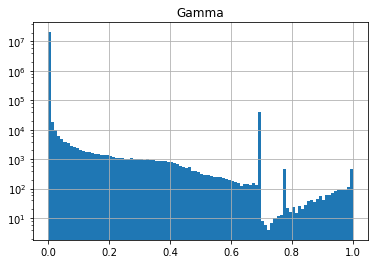

In [8]:
import matplotlib.pyplot as plt
df.hist(['Gamma'], bins=100)
plt.yscale('log')
plt.show()